# Introduction
This notebook gives an example how we do **EDA (explorative data analysis)**

It is the first one in a series of 5 notebooks. The next 2 notebooks load the results of this notebook and implement model comparison and model interpretation respectively.  The other notebooks show how to implement model training in production as well as scoring for new data which closes the loop of all steps you need to conduct for a predictive modeling project.

For a better understanding you should have **basic knowledge of predictive modelling**, i.e. know what a logistic regression is or cross-validation, for instance.

As example data source the well known **titanic data set** is chosen (https://www.kaggle.com/c/titanic/data). It is therefore a classification problem with the binary target *survived/not survived*. Even though you cannot compare the titanic case with a real life setting, the following steps pretty much reflect (on a small scale!) how we conduct data analysis in all our predictive modeling projects.

<br><br>
# 0. Packages and settings

We start by loading packages and do some basic settings (data and output locations, parameters, ...). 

Furthermore the ***0_init.R*** program defines many functions, mainly for plotting, which are frequently used in this notebook. The detailed implementation of these functions is not important for understanding the EDA approach presented here.


In [133]:
setwd("C:/My/Projekte/PredMod_Template/") 
source("./code/0_init.R")

<br><br>
# 1. ETL
We need to do some ETL (extract, transform, load) 
<br>
## 1.1 Read data and conduct quick check

In [134]:
df.orig = read_csv(paste0(dataloc,"titanic.csv"), col_names = TRUE) #read data

Parsed with column specification:
cols(
  pclass = col_character(),
  survived = col_integer(),
  name = col_character(),
  sex = col_character(),
  age = col_double(),
  sibsp = col_integer(),
  parch = col_integer(),
  ticket = col_character(),
  fare = col_double(),
  cabin = col_character(),
  embarked = col_character(),
  boat = col_character(),
  body = col_integer(),
  home.dest = col_character()
)


Let's do a quick check of the data:

In [135]:
df.orig %>% mutate_if(is.character, as.factor) %>% summary(.)

 pclass       survived                                  name          sex           age              sibsp            parch            ticket    
 1st:323   Min.   :0.000   Connolly, Miss. Kate           :   2   female:466   Min.   : 0.1667   Min.   :0.0000   Min.   :0.000   CA. 2343:  11  
 2nd:277   1st Qu.:0.000   Kelly, Mr. James               :   2   male  :843   1st Qu.:21.0000   1st Qu.:0.0000   1st Qu.:0.000   1601    :   8  
 3rd:709   Median :0.000   Abbing, Mr. Anthony            :   1                Median :28.0000   Median :0.0000   Median :0.000   CA 2144 :   8  
           Mean   :0.382   Abbott, Master. Eugene Joseph  :   1                Mean   :29.8811   Mean   :0.4989   Mean   :0.385   3101295 :   7  
           3rd Qu.:1.000   Abbott, Mr. Rossmore Edward    :   1                3rd Qu.:39.0000   3rd Qu.:1.0000   3rd Qu.:0.000   347077  :   7  
           Max.   :1.000   Abbott, Mrs. Stanton (Rosa Hunt:   1                Max.   :80.0000   Max.   :8.0000   Max.   :9.

+ We see that 38.2% of all passengers survived.
+ Some columns have missings
+ *name* and *ticket* seem to be useless for analysis as this information is too detailed
+ *cabin* seems to be a list of all cabins associated with a ticket (valid for several persons)  

In real data situations much more of these findings and data issues will pop up and need to be precisely reviewed usually together with business and data people.  
**It is absolut important to fully understand the input data for a prediction problem!**

Before transforming the data we create a copy of the original data. In case of bigger datasets which take much longer to be read this helps for faster implementation in case some erroneous tansformation will be done. Actually for the very small titanic data this is not really needed.

In [136]:
df = df.orig #"save" original data

<br>
## 1.2 Define target and train/test fold  
First we define the target and name it "target". This helps in reusing all the code for other cases

In [137]:
# Target
df = df %>% mutate(target = factor(ifelse(survived == 0, "N", "Y"), levels = c("N","Y")), #factor needed by caret package
                   target_num = ifelse(target == "N", 0 ,1)) #numeric version for some special analysis
summary(df[c("target","target_num")])

 target    target_num   
 N:809   Min.   :0.000  
 Y:500   1st Qu.:0.000  
         Median :0.000  
         Mean   :0.382  
         3rd Qu.:1.000  
         Max.   :1.000  

Now we directly specify the train/test fold.  

Here we use a **random 70/30 split**, but just because we do not have a time related variable. It is absolutely important to **do the split time based in real life situations!** First of all you usually want to predict something in the future (e.g. "will a customer churn"), so you best simulate this by a time based split. And as variable distributions as well as relations to the target can change over time, a pure random split usually would result in an overly positive predictive performance which you would not see in your first back testing in production.  

Last but not least, using time based features like calendar-week, day-of-month, etc. might result in some overfitting which you cannot identify by a random split.

In [138]:
# Train/Test fold
df$fold = factor("train", levels = c("train", "test"))
set.seed(123)
df[sample(1:nrow(df), floor(0.3*nrow(df))),"fold"] = "test" #random 70/30 split
summary(df$fold)

train  test 
  917   392

<br>
## 1.3 Feature engineering
Now one of the most important steps in predictive modeling has to be done: **Feature engineering**, i.e. deriving new information.

Even the most ambitious machine learning algorithms profit from feature engineering as it helps the algorithm to **"find the signal"**. In case of infinite data, an algorithm like deep neural nets is capable of finding all realations the features have with the target. But you will never have inifite data ... even in times of *big data*!

For the titanic data there is not much to do here, but in real life situations it is not unusual that you create **as many new features as original input data columns**. In such cases it often happens that most of the feature engineering is done on database side where the data originates.

In [139]:
df$deck = as.factor(str_sub(df$cabin, 1, 1)) #deck as first character of cabin
df$familysize = df$sibsp + df$parch + 1 #add number of siblings and spouses to number of parents and children
# TODO fare per person
summary(df[c("deck","familysize")]) 


      deck        familysize    
 C      :  94   Min.   : 1.000  
 B      :  65   1st Qu.: 1.000  
 D      :  46   Median : 1.000  
 E      :  41   Mean   : 1.884  
 A      :  22   3rd Qu.: 2.000  
 (Other):  27   Max.   :11.000  
 NA's   :1014                   

<br><br>
# 2 Metric features: Explore and adapt
We first define the names of the metric covariates in a simple character vector. In real life you will have much more metric features (and nominal as well), which might be created in parallel to your data analysis implementation but on database side by a data engineer. Then it makes much more sense to **administer the definition of the features together with some metadata** (implementation status, e.g. "under construction" or "ready", typical values, comments regarding derivation, etc.) in an external tool. For a pragmatic approach an execel sheet nicely fits the requirement and can be automaticaly read by your program. In such cases you should directly check the consistency of this ***datamodel.xls*** with the current data you load. 

In [140]:
# Define metric covariates
metr = c("age","fare")
setdiff(metr, colnames(df)) #all variables in data?
summary(df[metr]) 

character(0)

      age               fare        
 Min.   : 0.1667   Min.   :  0.000  
 1st Qu.:21.0000   1st Qu.:  7.896  
 Median :28.0000   Median : 14.454  
 Mean   :29.8811   Mean   : 33.295  
 3rd Qu.:39.0000   3rd Qu.: 31.275  
 Max.   :80.0000   Max.   :512.329  
 NA's   :263       NA's   :1        

<br>
## 2.1 Binning

We now create a **"binned" copy of every metric feature**, i.e. we group the values into bins determined by **10 quantiles** of the metric feature.  
This binned copy is used below for some plots. 
But more importantly, we later use these newly created nominal variables as features instead of the original variables for an elastic-net algorithm.  
<br>
Even though the binning throws away some information it has several **advantages in conjunction with a "linear model"** like the elastic-net (Hint: for a tree-based model this transformation has no advantage, see also tree-related discussion below):  
+ Ability to approximate **nonlinear effects** with a linear model (since each bin can get its own effect)
+ Elegant handling of **missing values** as these can be grouped into a seperate member named "(Missing)" for instance
+ No worries about **outliers in feature space** as these are nicely grouped with non-outliers in the edge bins
+ Also **skewness** (see below) is not an issue any more due to the quantile based binning

In [141]:
# Create nominal variables for all metric variables  
metr_binned = paste0(metr,"_BINNED_")
df[metr_binned] = map(df[metr], ~ {
  # Hint: Adapt sequence increment in case you have lots of data 
  cut(., unique(quantile(., seq(0, 1, 0.1), na.rm = TRUE)), include.lowest = TRUE)  #cut by quantiles
})

# Convert missings to own level "(Missing)"
df[metr_binned] = map(df[metr_binned], ~ fct_explicit_na(., na_level = "(Missing)")) 
summary(df[metr_binned],11)

     age_BINNED_       fare_BINNED_
 [0.167,14]:107   [0,7.57]   :131  
 (14,19]   :118   (7.57,7.85]:144  
 (19,22]   :108   (7.85,8.05]:146  
 (22,25]   :110   (8.05,10.5]:108  
 (25,28]   : 93   (10.5,14.5]:128  
 (28,31]   : 98   (14.5,21.7]:130  
 (31,36]   :121   (21.7,27]  :128  
 (36,42]   : 96   (27,41.6]  :134  
 (42,50]   :100   (41.6,78.1]:128  
 (50,80]   : 95   (78.1,512] :131  
 (Missing) :263   (Missing)  :  1  

<br>
## 2.2 Handling of missings, outliers, skewness
When we want to use the original metric variables with **algorithms like "standard" GLM (generalized linear models, including logistic regression), SVM (support vector machines) or deep neural nets**, we now need to **care about missings, outliers and skewness** occuring in the features. 

All the following coding steps help these **non-tree-based algorithms to find the signal**. Why do we state "non-tree-based" here? Actually **all algorithms based on decision trees**, like random forest or boosted decision trees (e.g. xgboost), do not suffer from these issues: Missings are treated as a special value which can be used in all splits, feature outliers almost do not influence tree splits, feature skewness need not be handled by a montone transformation as trees are invariant to such adaptions. The latter is also the reason why above processed binning is useless for tree-based algorithms.

First of all we remove features with too many missings. **But how much is too many?** In classic statistical analysis you 
still see that features (or *covariates*) are removed if they contain 50% missings or more. Actually in data science, utilizing machine
learning algorithms, this threshold is much higher. It is not unusual to **keep variables with 99% missings**. This threshold is also used in the following and can be seen as a rule of thumb (and is therefore rough and not applicable in all cases).  
For titanic the metric features are far away from this threshold.  

**Later we will care about the missings more detailed, i.e. remove them by imputation**. But for now we keep them as is for some additional analysis.

In [142]:
# Remove covariates with too many missings from metr 
misspct = map_dbl(df[metr], ~ round(sum(is.na(.)/nrow(df)), 3)) #misssing percentage
print(misspct[order(misspct, decreasing = TRUE)]) #view in descending order
(remove = names(misspct[misspct > 0.99])) #vars to remove
metr = setdiff(metr, remove) #adapt metadata
metr_binned = setdiff(metr_binned, paste0(remove,"_BINNED_")) #keep "binned" version in sync

  age  fare 
0.201 0.001 


character(0)

We already create some initial plots to check whether there are **outliers or skewed distributions**. The distributions are stratified by the target. The reason behind this kind of display is explained later.

      age               fare        
 Min.   : 0.1667   Min.   :  0.000  
 1st Qu.:21.0000   1st Qu.:  7.896  
 Median :28.0000   Median : 14.454  
 Mean   :29.8811   Mean   : 33.295  
 3rd Qu.:39.0000   3rd Qu.: 31.275  
 Max.   :80.0000   Max.   :512.329  
 NA's   :263       NA's   :1        

[1] "age"
[1] "fare"


[[1]]
NULL


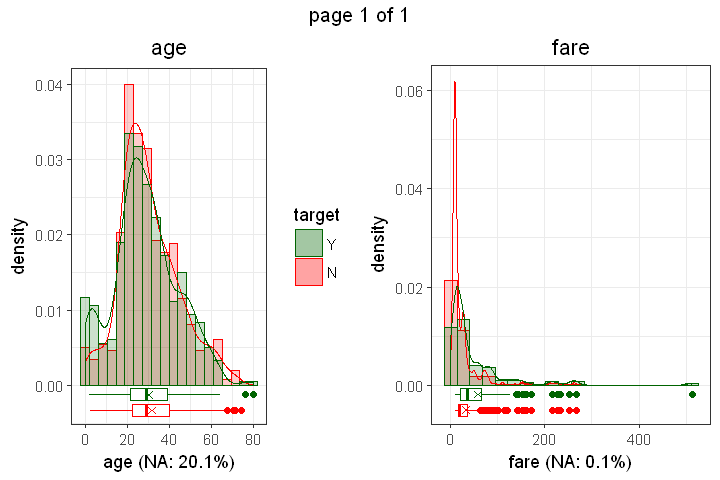

In [143]:
# Check for outliers and skewness
summary(df[metr]) 
options(warn = -1) #suppress unwanted messages
plots = suppressMessages(get_plot_distr_metr(df, metr, color = twocol, missinfo = misspct, ylim = c(0,1))) #distribution plot
options(repr.plot.width = 6, repr.plot.height = 4) #adapt this for different resolution
marrangeGrob(suppressMessages(plots), ncol = 2, nrow = 1) #arrange plots
options(warn = 0) #reset warnings

For "age" we do not see anything unusual. 

But for "fare" we can clearly identify at least one clear outlier above 500. Furthermore the distribution is highly right-skewed.  
An easy approach to handle outliers is to **winsorize the data**, i.e. set all values below the .01 quantile to the quantile value and do the same for data above the .99 quantile. Sometimes this already fixes some skewness in extreme cases.  


In [144]:
# Winsorize
df[metr] = map(df[metr], ~ winsorize(., 0.01, 0.99)) #hint: one might want to plot again before deciding for forthcoming log-trafo

Skewness: The most common case are **right-skewed** variables as you often face features that are unrestricted to the right but restricted to the left by zero. This kind of skewness can often be fixed a **log-transformation**. A more flexible alternative is the so-called Box-Cox trafo for which the log trafo is a special case. The Box-Cox seeks for normality which is useful but not absoutely needed.

In [145]:
# Log-Transform
tolog = c("fare") #variable to transform
df[paste0(tolog,"_LOG_")] = map(df[tolog], ~ {if(min(., na.rm=TRUE) == 0) log(.+1) else log(.)}) #log(x) or log(x+1) trafo
metr = map_chr(metr, ~ ifelse(. %in% tolog, paste0(.,"_LOG_"), .)) #adapt metadata (and keep order)
names(misspct) = map_chr(names(misspct), ~ ifelse(. %in% tolog, paste0(.,"_LOG_"), .)) #keep misspct in sync
summary(df[paste0(tolog,"_LOG_")])

   fare_LOG_    
 Min.   :0.000  
 1st Qu.:2.186  
 Median :2.738  
 Mean   :2.977  
 3rd Qu.:3.474  
 Max.   :5.574  
 NA's   :1      

<br>
## 2.3 Plot the finalized features
We are now ready to get the final distribution plot for the metric features. This plot has several characteristics helping to judge the features:  
+ We also print the **univariate variable importance**, which, for a classification problem, is identical with the **in-sample (or "training") AUC** (area under the curve) you can achieve if you solely use one feature to predict the target 
+ Before calculating it we **impute the missing values with random non-missing values** from the same variable which assures that the univariate variable importance is not overly optimistic due to a restriction to the non-missing variable values. 
+ But we add the percentage of missings to better justify the importance of the feature 
+ The **stratification by the target** helps to identify the effect on the target
+ The boxplots below the distribution plots supports in **identifying outliers** and in **comparison of the mean** (marked by the cross) and the median (marked by the bar) of the feature in the two target strata
+ We additionally plot the effect of the binned versions of the features which sometimes is advantageous in visualizing the effect on the target (with the **dotted line showing the base ratio of the target**, i.e. 38% survival rate). E.g. if you have a metric variable with lots of data in a small range, this plot pulls apart possible effects. Do not get confused by the unequal percentage of observations for each bin which is printed in brackets behind the bin edges; this can occur in case of too few distinct values of the original variable 
+ The binned version plot also helps in **identifying informative missings** by comparing the effect of the "(Missing)" bin with the others.


Especially the next to last bullet is important. If you already see here an effect which is **"too good to be true"**, you might have created some form of ***data leakage***. This isssue always occurs if you have some data relations in your training data that would not occur in a similar way for your future test data and therefore would result in a much lesser predictive performance for the latter. The data leakage can have several reasons: you might have incorporated **"self-predictors" or "information from the future"** as explained for the nominal features below. In such a case you need to fix the leakage, e.g. by removing the self-predictors from your feature vector.

fare_LOG_       age 
     0.67      0.52

[1] "age"
[1] "fare_LOG_"
[1] "age_BINNED_"
[1] "fare_BINNED_"


[[1]]
NULL


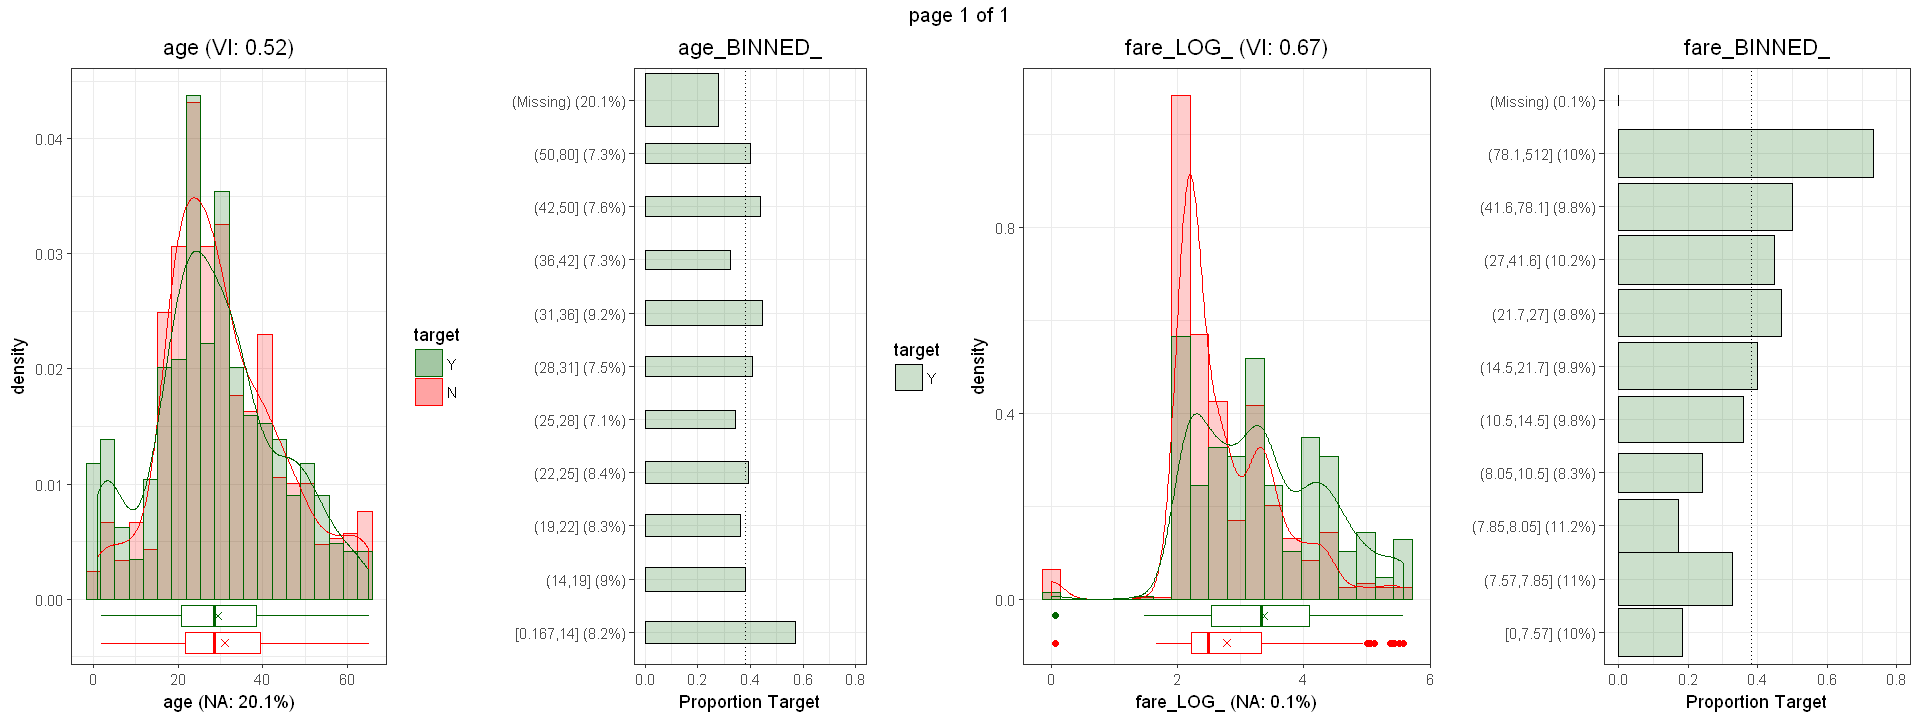

In [146]:
# Univariate variable importance: with random imputation!
(varimp_metr = (filterVarImp(map_df(df[metr], ~ impute(.)), df$target, nonpara = TRUE) %>% rowMeans() %>% 
                  .[order(., decreasing = TRUE)] %>% round(2)))

# Plot 
options(warn = -1) #suppress unwanted messages
plots1 = suppressMessages(get_plot_distr_metr(df, metr, color = twocol, 
                                             missinfo = misspct, varimpinfo = varimp_metr, ylim = NULL)) #distribution plot
plots2 = suppressMessages(get_plot_distr_nomi(df, metr_binned, color = twocol, varimpinfo = NULL, inner_barplot = FALSE,
                                              min_width = 0.2, ylim = c(0,0.8))) #binned variable plot
plots = mapply(list, plots1, plots2) #zip plots
#options(jupyter.plot_mimetypes = "image/svg+xml")
options(jupyter.plot_mimetypes = "image/png")
options(repr.plot.width = 16, repr.plot.height = 6) #adapt this for different resolution
marrangeGrob(suppressMessages(plots), ncol = 4, nrow = 1) #arrange plots
options(warn = 0) #reset warnings

#TODO: VI of binned variables

The following findings can be derived from the plots:
+ We see that children have a higher probability to survive. 
+ Apart from that only the **lower survial rate in case of a missing age** (see the binned age plot) pops up regarding passenger age. Even though this effect is not huge it hints to a possible data leakage, i.e. that age was recorded after the accident which a higher probability of response due to survival of the passenger. This example for "information from the future" nicely corresponds to typical business data situations where special data flags are set after the event of interest and are therefore useless for predicting the future. We emphasize this issue again as it is **one of the biggest problems in real life predictive models!** Actually for the titanic data an alternative explanation can be that 3rd class passengers that have a lower survival rate (see the forthcoming analysis) have not reported their age. If this is the case you can keep the feature.   
+ Furthermore we can identify that ***fare*** is highly predictable for the target (AUC: 0.67) which is due to a nearly linear trend. Keep in mind that this is still a **univariate influence** and might change if we adjust for the other features in the final multivarite model. E.g. the *fare* effect might be ***confounded*** by the passenger class which might be the causal reason behind this effect as first class passengers (which pay a higher fare) are nearer to the deck and due to this reason had a higher chance to survive.  
+ Additionally we nicely see how the log trafo also rectifies the low fares showing now a gap between the zero dollar fares and the rest.  
  
  
By this discussion of just the two plots you get an impression what has to be checked in real life situations with dozens of metric variables. 

<br>
## 2.4 Correlation analysis

Now we investigate the relation between the metric features themselves by a correlation analysis.  

When using **classical regression approaches** (without any regularization by penalization) this is would be a very important step as highly correlated covariates would lead to the so-called **multicollinearity** problem. As a consequence the estimates of the model parameters (i.e. the beta coefficients in the model equation) would be highly instable and the predicctive performance of the model would decrease drastically.  

In times of robust machine learning algorithms that can handle this issue, we use the correlation analysis mostly to **identify "duplicates" of variables**, which can be removed without any loss. It is not unusual that under a high amount of metric features you find several which measure the same thing, e.g. revenue-per-month and revenue-per-year, which would pop up in a correlation matrix plot. In such a case we remove the variable which has more missings.  

Therefore we directly plot the missing rate for each variable beside the variable name. Futhermore we only **plot the correlations above a cutoff value** in order to keep the plot manageable in case of many metric variables. Often we choose .97, but then only look at **correlations above .99 for the "duplicate" candidates**. For the small titanic data none of above advices are relevant.

We almost always plot the **absolute Spearman correlation**, which is based on the ranks of the variable values and more robust against outliers than the better known Pearson correlation. Since we took care about outliers by previous steps this might not be needed, but furthermore the Spearman correlation can also better **identify non-linear (but monotone) correlations**. And we take the absolute value as for our purpose it does not make a difference if the correlation is negative or positive.

Last but not least this analysis also helps to understand the data in hand.

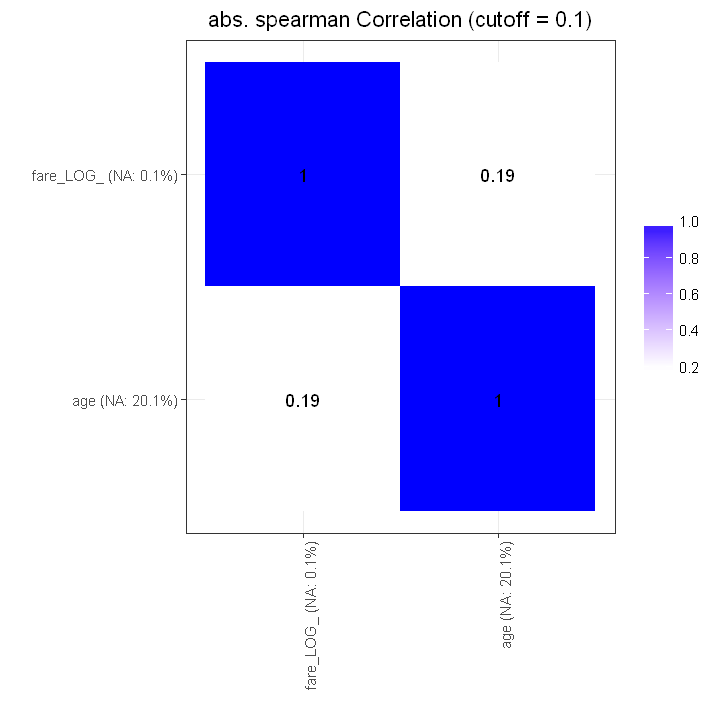

In [147]:
# Plot absolute spearman correlation for metric features
plot = get_plot_corr(df, input_type = "metr", vars = metr, 
                     missinfo = misspct, cutoff = 0.1) #plot all variables with at least one correlation above 0.1
options(repr.plot.width = 6, repr.plot.height = 6) #adapt this for different resolution
plot

In [148]:
# Remove highly/perfectly (>=99%) correlated variables (i.e. the ones with less NA!)
remove = c("xxx") #put at xxx the variables to remove
metr = setdiff(metr, c("xxx")) #remove
metr_binned = setdiff(metr_binned, paste0(c("xxx"),"_BINNED_")) #keep "binned" version in sync

<br>
## 2.5 Time or train/test-fold dependency
Actually we are ready with the analysis of our metric features. Nearly! One final important step is lacking. 

We need to check whether the **data distributions are different between the train and test data**. Usually this occurs due to a time dependency (in case of a timely based train/test split) of the features. For typical business data this hints to a change in some process, related to business (opened more stores in some regions, e.g.) or data (flag *xyz* now underlies a different definition). If it occurs, it is bad news as it might degrade your predictive performance on test data and you need to decide how to handle this feature distribution change: restrict to just newer data in training or remove the time-dependant feature or add a "process-has-changed-here"-flag? There is no default solution here. You need to decide case-by-case.

To check the dependencies we just use our usual metric feature distribution plot, but now take the **fold information as the target**. Then we just plot the features with a variable importance (AUC regarding the new target) above a threshold.

If you also have a detailed time variable like date, **a better alternative** is to treat the date as a new metric target and create the same plots as for a regression task (not shown in this notebook).

For the titanic data our random split just results in some minor dependencies due to random variability which is below the threshold.

In [152]:
# Univariate variable importance (again ONLY for non-missing observations!) for time/fold dependency
df$fold_test = factor(ifelse(df$fold == "test", "Y", "N")) #new target
(varimp_metr_fold = filterVarImp(df[metr], df$fold_test, nonpara = TRUE) %>% rowMeans() %>% 
  .[order(., decreasing = TRUE)] %>% round(2))

# Plot: only variables with with highest importance above threshold
metr_toprint = names(varimp_metr_fold)[varimp_metr_fold >= 0.55] #restrict to
plots = get_plot_distr_metr(df, metr_toprint, color = c("blue","red"), target_name = "fold_test", 
                            missinfo = misspct, varimpinfo = varimp_metr_fold, ylim = ylim)
plots

fare_LOG_       age 
     0.52      0.51

list()

<br>
## 2.6 Missings "again", now impute

After we finished all processing of the metric variables we can now **impute missing values**. But before, we derive for each feature comprising any missing values, a separate **missing value indicator** (i.e. a binary flag) which we add to the feature vector (see next section). This is due to the chance that the missings can be informative wich means that they have predictive capability with regard to the target.  

We choose a **random imputation** here becauese we are still in the explorative modus and do not want the missing indicator effect get mixed with an effect resulting from the median of a feature, wich would happen when we would use the **typical median imputation**. Be aware that for any scoring data you prepare, you never should use random imputation as this created the chance of nonsense predictions due to imputation of an outlier which has a small but not zero probability to get chosen as imputation value.

In [118]:
# Create mising indicators
(miss = metr[map_lgl(df[metr], ~ any(is.na(.)))]) #get all metric features with missings (and print)
df[paste0("MISS_",miss)] = map(df[miss], ~ as.factor(ifelse(is.na(.x), "miss", "no_miss"))) #create indicators
summary(df[,paste0("MISS_",miss)]) 

# Impute missings with randomly sampled value
df[miss] = map(df[miss], ~ impute(., type = "random"))
summary(df[metr]) #check

[1] "age"       "fare_LOG_"

    MISS_age    MISS_fare_LOG_
 miss   : 263   miss   :   1  
 no_miss:1046   no_miss:1308  

      age            fare_LOG_    
 Min.   : 0.9167   Min.   :0.000  
 1st Qu.:21.0000   1st Qu.:2.186  
 Median :28.0000   Median :2.738  
 Mean   :29.8542   Mean   :2.977  
 3rd Qu.:39.0000   3rd Qu.:3.474  
 Max.   :65.0000   Max.   :5.574  

<br><br>   
 # 3. Nominal features: Explore and adapt

In this section we do a similar analysis for the **nominal (categorical) features**. But due to the different scale, the handling of the several issues are approached differently.

First of all you need to decide which ones are the nominal features. At least all variables containing any characters must be treated as nominal. But also 0/1-flags are added. Futhermore numerically coded variables where the single value has "no meaning", i.e. you cannot do any calculations with them, like for german postal codes. And it is **not unusual to also treat some clear numeric variables as categorical**, e.g. a month (ranging from 1-12) or day-of-week (ranging from 1-7). At least the explorative plots you will see later can visualize data relations better when these kind of variables are treated as nominal.  

For the final model we might switch again to the metric scale depending on the algorithm we choose; basically the differentiation of **non-tree based versus tree-based** is important here, furthermore the **number of factor levels** plus the overall data volume. The latter is an issue due to any needed dummy coding (or *1-hot encoding*) of the nominal variables which can drastically increase the data volume that must be processed by the prediction algorithm.  
  
In a dummy encoding you create a binary flag variable for each level of a nominal variable. For each data record only one of these flags has the value 1, all others are 0 (-> "1-hot"). This transformation is needed for all non-tree based algorithms. Even some implementations of tree based algorithms (e.g. xgboost) need pure metric features (and therefore 1-hot encoded variables).

But a **tree-based algorithm** is in principle capable of handling any nominal feature as one and only one pure metric variable (after encoding to numeric values BUT not with a 1-hot encoding) which then comprises much less space than the 1-hot encoded variant. Importantly, this argument also implies that for **any non-tree based algorithm we are stuck to the nominal scale and 1-hot encoding!** For the deep learning guys outside there who now protest: We do not encounter any numerical embedding approaches here. 
  
TODO: Explain dummy coding versus metric as kind of feature engineering for trees.
  
First we add the missing indicators (0/1-flags) to the nominal feature vector and create a quick overview.

In [119]:
nomi = c("pclass","sex","sibsp","parch","deck","embarked","boat","home.dest")
nomi = union(nomi, paste0("MISS_",miss)) #add missing indicators
df[nomi] = map(df[nomi], ~ as.factor(as.character(.))) #map to factor
options(width = 160) #for better plotting of the summary
summary(df[nomi])

 pclass        sex      sibsp       parch           deck             embarked        boat                    home.dest      MISS_age    MISS_fare_LOG_
 1st:323   female:466   0:891   0      :1002   C      :  94   Cherbourg  :270   13     : 39   New York, NY        : 64   miss   : 263   miss   :   1  
 2nd:277   male  :843   1:319   1      : 170   B      :  65   Queenstown :123   C      : 38   London              : 14   no_miss:1046   no_miss:1308  
 3rd:709                2: 42   2      : 113   D      :  46   Southampton:914   15     : 37   Montreal, PQ        : 10                                
                        3: 20   3      :   8   E      :  41   NA's       :  2   14     : 33   Cornwall / Akron, OH:  9                                
                        4: 22   4      :   6   A      :  22                     4      : 31   Paris, France       :  9                                
                        5:  6   5      :   6   (Other):  27                     (Other):308   

<br>
## 3.1 Handling of missings and too-many-members features
First we care about the missing: This is an easy task for categorical features. We just convert all missing to a separate factor level which we name "(Misssing)".  
Before checking again we do some more cosmetics: We reorder the levels of some ordinal variables as we want these levels to be plotted later in the "correct" order.

In [120]:
# Convert missings to own level ("(Missing)")
df[nomi] = map(df[nomi], ~ fct_explicit_na(.))

# Reorder "numeric" nominal variables
ord = c("sibsp", "parch") #variables with ordinal scale
df[ord] =  map(df[ord], ~ fct_relevel(., levels(.)[order(as.numeric(levels(.)), na.last = FALSE)])) #remap levels
summary(df[nomi])

 pclass        sex      sibsp       parch             deck             embarked          boat                    home.dest      MISS_age    MISS_fare_LOG_
 1st:323   female:466   0:891   0      :1002   (Missing):1014   Cherbourg  :270   (Missing):823   (Missing)           :564   miss   : 263   miss   :   1  
 2nd:277   male  :843   1:319   1      : 170   C        :  94   Queenstown :123   13       : 39   New York, NY        : 64   no_miss:1046   no_miss:1308  
 3rd:709                2: 42   2      : 113   B        :  65   Southampton:914   C        : 38   London              : 14                                
                        3: 20   3      :   8   D        :  46   (Missing)  :  2   15       : 37   Montreal, PQ        : 10                                
                        4: 22   4      :   6   E        :  41                     14       : 33   Cornwall / Akron, OH:  9                                
                        5:  6   5      :   6   A        :  22         

As already mentioned, the nominal variables will later be converted to 1-hot encoding columns, resulting in **one colum per each member of a nominal variable**. In real life situations with more data than in the titanic case you need to "cut" the variables with lots of members if you do not want to **run into memory space limitations**.  

This is done in the next code snippet: We decide to **collapse the less frequent occuring levels** to a new artficial level "\_OTHER\_" and only the top 10 members per feature are kept as is. This threshold (*topn_toomany*) is somewhat arbitrary here and will be different for other data.  Be aware that for this purpose we create a new variable with a "_OTHER_" suffix and exchnage it with the original variable in the metadata.

Again: For a tree-based model there are other approaches ("encodings"). But as the algorithm selection is yet to come we have to accept a compromise supporting also non-tree based models. This is already a hint that **data preprocessing in the final productive model can be different from the explorative phase**. We usually address this by the 2 attributes "explore_type" and "model_type" in our metadata, which can differ for some variables in the way that *explore_type = nominal* might have a different *model_type = metric* (but not vice versa).

In [130]:
# Create compact covariates for "too many members" columns 
topn_toomany = 10
(levinfo = map_int(df[nomi], ~ length(levels(.))) %>% .[order(., decreasing = TRUE)]) #get number of levels and print in decending order
(toomany = names(levinfo)[which(levinfo > topn_toomany)]) #which ones comprise too many levels
toomany = setdiff(toomany, c("xxx")) #set exception for important variables
df[paste0(toomany,"_OTHER_")] = map(df[toomany], ~ fct_lump(., topn_toomany, other_level = "_OTHER_")) #collapse
nomi = map_chr(nomi, ~ ifelse(. %in% toomany, paste0(.,"_OTHER_"), .)) #adapt metadata (and keep order)
summary(df[paste0(toomany,"_OTHER_")], topn_toomany + 2) #check

home.dest_OTHER__OTHER_                    deck                   parch                   sibsp                embarked                  pclass 
                     10                       9                       8                       7                       4                       3 
                    sex                MISS_age          MISS_fare_LOG_ 
                      2                       2                       2

[1] "akhg"


character(0)

ERROR: Error: Column `_OTHER_` not found


<br>
## 3.2 Plot the finalized features
You see we are faster in reaching the final state of our nominal features compared to the metric ones.  

Before plotting we list the univariate variable importance (AUC in this case) in descending order for a quick check.

In [122]:
# Univariate variable importance
(varimp_nomi = filterVarImp(df[nomi], df$target, nonpara = TRUE) %>% rowMeans() %>% #rowMeans needed for multiclass target
    .[order(., decreasing = TRUE)] %>% round(2))

sex           pclass      boat_OTHER_             deck         embarked            parch         MISS_age home.dest_OTHER_            sibsp 
            0.76             0.67             0.64             0.63             0.58             0.57             0.54             0.54             0.54 
  MISS_fare_LOG_ 
            0.50

The following plot per nominal feature has some nice properties helping in understanding the data:
+ Again, we plot the **univariate variable importance** in the header.
+ The grey bar chart on the left shows the **distribution of the nominal variable** and is also reflected by the percentage values inside the brackets beside the level name. First of all this helps in identifying rare members which is important when judging the effect of the member onto the target.
+ This effect itself is visualized by the colored bars. The width of the bars are proportional to their occurence (and therefore show the same as the grey bars)
+ The vertical refernce line denotes the **base rate** of the target (38.2% survived). So you can directly see which member has an average target value above or below the overall average
+ Be aware that the x-axis scale is NOT the same for all plots
+ Features on an ordinal scale are shown in the correct order

[1] "pclass"
[1] "sex"
[1] "sibsp"
[1] "parch"
[1] "deck"
[1] "embarked"
[1] "boat_OTHER_"
[1] "home.dest_OTHER_"
[1] "MISS_age"
[1] "MISS_fare_LOG_"


[[1]]
NULL


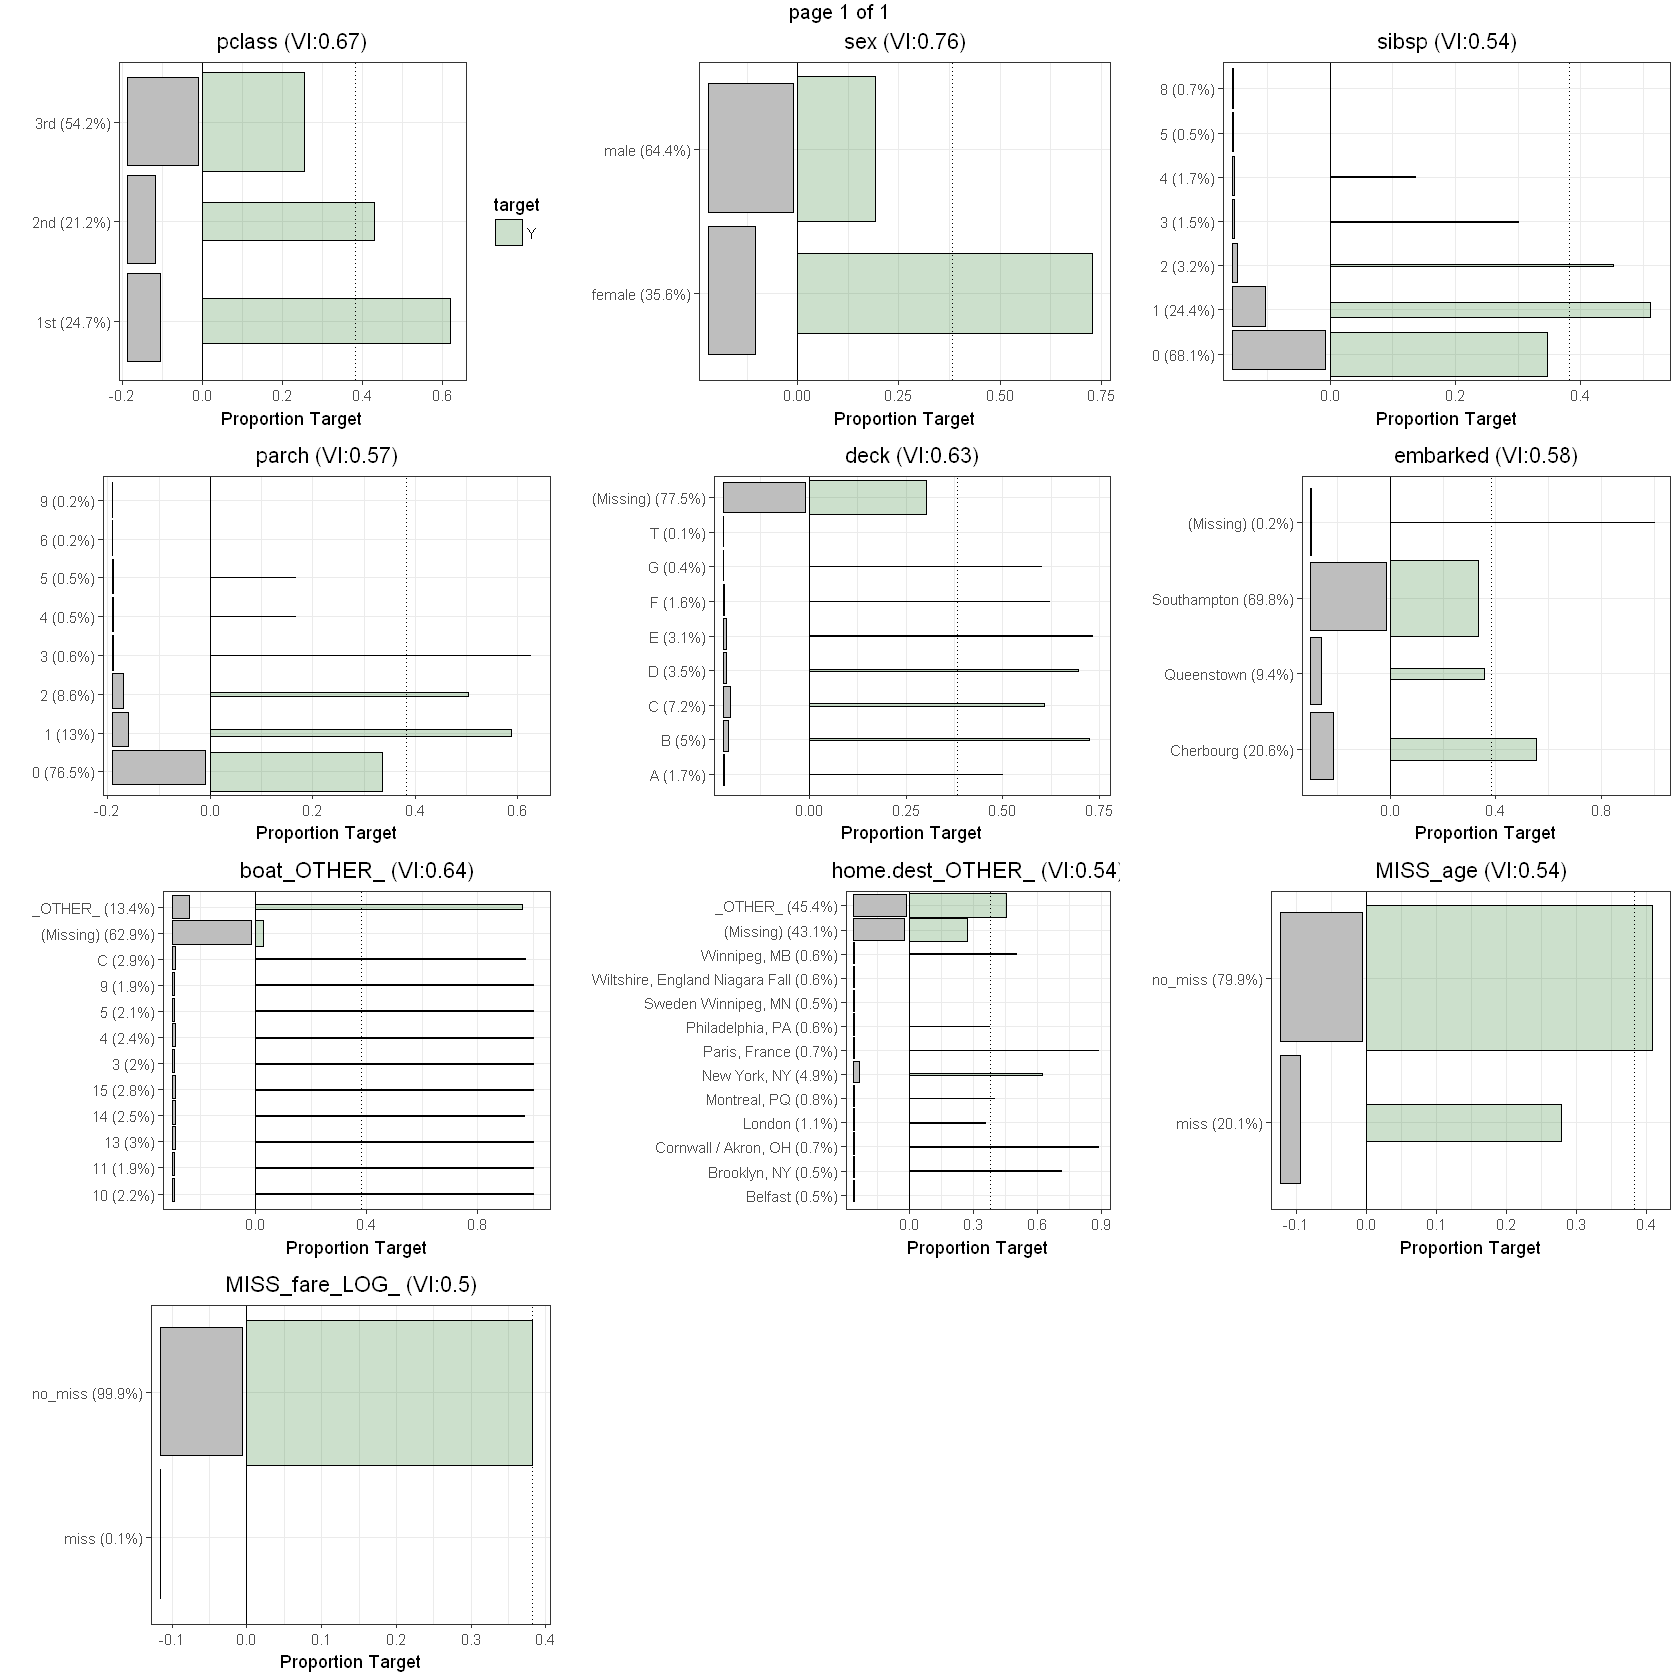

In [123]:
# Check
plots = suppressMessages(get_plot_distr_nomi(df, nomi, color = twocol, varimpinfo = varimp_nomi, inner_barplot = TRUE,
                                             min_width = 0, ylim = NULL))
#options(jupyter.plot_mimetypes = "image/svg+xml")
#options(jupyter.plot_mimetypes = "image/png")
options(repr.plot.width = 14, repr.plot.height = 14) #adapt this for different resolution
marrangeGrob(plots, ncol = 3, nrow = 4)

Lots of interesting findings can be derived from the plots. We just list some of them:
+ Passenger Class (*pclass*) and *sex* have a high impact on survival rate: Lucky Rose, sorry Jack ....
+ We see some extreme effects for *sibsp* and *parch*, i.e. zero or at least low survival rate for the members with a high value. Actually these correspond to very rare members and therefore **do not represent a real signal!**
+ *deck* and *home.dest_OTHER_* have **informative missings** as the probability of survival is highly reduced. Similarly to the missing age effect it is questionable whether this is not some form of data leakage (see explanations for age above). Btw, the missing age effect can also be seen in the plot of the **missing indicator** of age (*MISS_age*).
+ But the most extreme effect occurs for *boat_OTHER_*. It seems like a perfect predictor for survival. Actually if you check what this variable means, you notice that it denotes the lifeboat and is therefore clearly **information from the future**. A passenger first must have survived before the number of the lifeboat which catched him/her is known. We need to remove this variable form the predictor (feature) set. Again we need to emphasize here, that if you see in these plots an effect which seems to be too good to be true, all your alarm rings should start. And always be aware that this issue can come along in more subtle ways than for this easy identifiable example.

In [124]:
# Remove Self-predictors
nomi = setdiff(nomi, "boat_OTHER_")

<br>
## 3.3 Correlation analysis
We have reached the investigation of **dependencies between the nominal features**.  

Basically we use a similar approach to the correlation analysis for the metric variables, with the absolute Spearman correlation exchanged by the ***(corrected) contingency coefficient***. This metric also varies between 0 and 1 with 0 denoting absolute independency and 1 absolute dependency between the features.

And like for the metric features we also only remove the ones which show a really high "correlation", **BUT only if the number of levels between the "correlated" features do NOT highly differ**. In turn this means that we keep 2 features which are highly dependant (maybe also perfectly depdendant, i.e. with a contingency coefficient equals 1), like it would happen for typical "product groups" and "product types" for instance, as one of these variables is a grouping of the other and helps the algorithm to find the signal (if it is there). But if both features comprise nearly the same number of levels we can remove one of them without any loss as both are features are kind of equal.  

For the titanic data we do not see any high dependencies. Be aware that we also only plot variables which have at least one "correlation" above the **cutoff**. In such a case the metric is printed in white. And variables with high dependencies are clustered together. Both helps to get the overview quicker in case of a high amount of nominal features. 

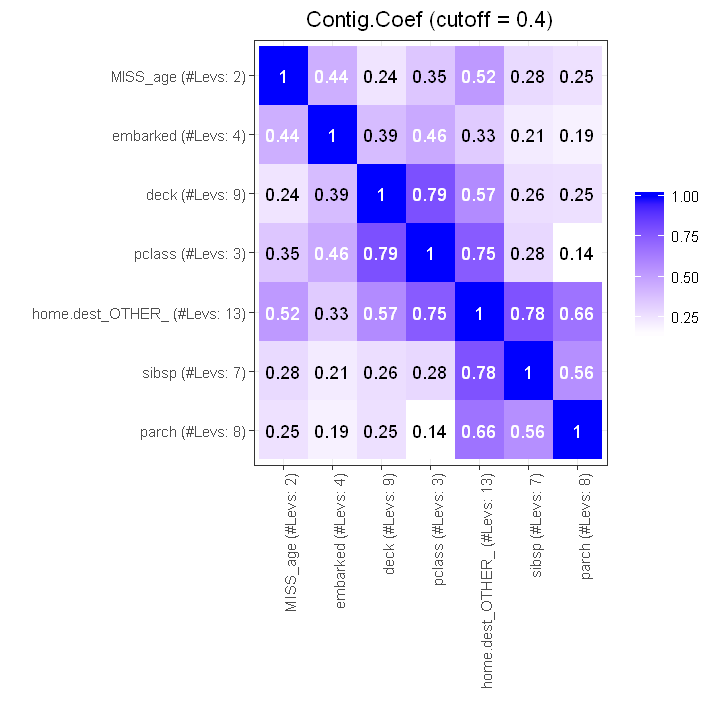

In [125]:
# Plot corrected contingency coefficient for nominal features
plot = get_plot_corr(df, input_type = "nomi", vars = nomi, cutoff = 0.4) #plot all variables with at least one conitg. coeff. above 0.4
options(repr.plot.width = 6, repr.plot.height = 6) #adapt this for different resolution
plot



In [126]:
# Remove highly/perfectly (>=99%) correlated (the ones with less levels!) 
remove = c("xxx") #put at xxx the variables to remove
nomi = setdiff(nomi, remove) #put at xxx the variables to remove

<br>
## 3.4 Time or train/test-fold dependency for nominal features
Final step: Check the dependency of the nominal features regarding the fold split. See the explanations for the metric features above, as we are doing the same. Again no findings here since we are not dealing with a real time-based split.

In [127]:
# Univariate variable importance (again ONLY for non-missing observations!) for time/fold dependency
(varimp_nomi_fold = filterVarImp(df[nomi], df$fold_test, nonpara = TRUE) %>% rowMeans() %>% 
   .[order(., decreasing = TRUE)] %>% round(2))

# Plot: only variables with with highest importance above threshold
nomi_toprint = names(varimp_nomi_fold)[varimp_nomi_fold >= 0.55]
plots = get_plot_distr_nomi(df, nomi_toprint, color = c("blue","red"), target_name = "fold_test", inner_barplot = FALSE,
                            varimpinfo = varimp_nomi_fold, ylim = c(0,1))


home.dest_OTHER_           pclass              sex            parch            sibsp         MISS_age             deck         embarked   MISS_fare_LOG_ 
            0.53             0.52             0.52             0.51             0.51             0.51             0.51             0.50             0.50

list()

<br>
## 4. Save the final state
We are finished with the exploration and adaption of our features.  

Therefore we can save the current state for the forthcoming steps of model comparison and model interpretation. For this task we save the feature names in a character vector separately for the "normal" and the binned versions which we will use with different algorithms during the model comparison. Notice the removal of the missing indicators for the binned version; this information is comprised in the newly created "(Missing)" member. The purpose behind the multiple formulas will be resolved in the next notebook.

In [128]:
# Define final features and formulas
features = c(metr, nomi)
formula = as.formula(paste("target", "~ -1 + ", paste(features, collapse = " + ")))  
formula_rightside = as.formula(paste("~ -1 + ", paste(features, collapse = " + "))) 
features_binned = c(metr_binned, setdiff(nomi, paste0("MISS_",miss))) #do not need indicators if binned variables
formula_binned = as.formula(paste("target", "~", paste(features_binned, collapse = " + ")))
formula_binned_rightside = as.formula(paste("~", paste(features_binned, collapse = " + ")))

# Some final checks
options(width = 150)
summary(df[features])
setdiff(features, colnames(df))
summary(df[features_binned])
setdiff(features_binned, colnames(df))

# Save image 
rm(df.orig, plots, plots1, plots2) #remove possibly big objects
save.image("1_explore.rdata") #save the rest as image

      age            fare_LOG_     pclass        sex      sibsp       parch             deck             embarked               home.dest_OTHER_
 Min.   : 0.9167   Min.   :0.000   1st:323   female:466   0:891   0      :1002   (Missing):1014   Cherbourg  :270   _OTHER_             :594    
 1st Qu.:21.0000   1st Qu.:2.186   2nd:277   male  :843   1:319   1      : 170   C        :  94   Queenstown :123   (Missing)           :564    
 Median :28.0000   Median :2.738   3rd:709                2: 42   2      : 113   B        :  65   Southampton:914   New York, NY        : 64    
 Mean   :29.8542   Mean   :2.977                          3: 20   3      :   8   D        :  46   (Missing)  :  2   London              : 14    
 3rd Qu.:39.0000   3rd Qu.:3.474                          4: 22   4      :   6   E        :  41                     Montreal, PQ        : 10    
 Max.   :65.0000   Max.   :5.574                          5:  6   5      :   6   A        :  22                     Cornwall / Akr

character(0)

     age_BINNED_       fare_BINNED_ pclass        sex      sibsp       parch             deck             embarked               home.dest_OTHER_
 (Missing) :263   (7.85,8.05]:146   1st:323   female:466   0:891   0      :1002   (Missing):1014   Cherbourg  :270   _OTHER_             :594    
 (31,36]   :121   (7.57,7.85]:144   2nd:277   male  :843   1:319   1      : 170   C        :  94   Queenstown :123   (Missing)           :564    
 (14,19]   :118   (27,41.6]  :134   3rd:709                2: 42   2      : 113   B        :  65   Southampton:914   New York, NY        : 64    
 (22,25]   :110   [0,7.57]   :131                          3: 20   3      :   8   D        :  46   (Missing)  :  2   London              : 14    
 (19,22]   :108   (78.1,512] :131                          4: 22   4      :   6   E        :  41                     Montreal, PQ        : 10    
 [0.167,14]:107   (14.5,21.7]:130                          5:  6   5      :   6   A        :  22                     Cornwal

character(0)